# Assignment 1 - Michela Sessi 777760

## Image stitching

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

Creo una funzione di stitching da applicare a partire da due immagini distinte. 
Le variabili della funzione sono le due immagini, la direzione di merge (orizzontale o verticale), il colore delle linee rappresentanti i match tra i keypoints e un attributo booleano di settaggio delle dimensioni per l'immagine finale.

In [2]:
def stitch(img1, img2,
          direction="vertical", #direction="horizontal" a seconda della direzione di unione immagine
          col_match=(255,255,0),  #col=colore linee match, se inverto i canali cambio anche colore del match
          set_dim=False, set_h=0, set_w=0):  #set_dim=true per settare a priori altezza e larghezza del result
    
    sift = cv.xfeatures2d.SIFT_create()
    
    (kps1, features1) = sift.detectAndCompute(img1, None)
    img1_kps = cv.drawKeypoints(img1, kps1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    (kps2, features2) = sift.detectAndCompute(img2, None)
    img2_kps = cv.drawKeypoints(img2, kps2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    #Associa features tra le due immagini
    bf = cv.BFMatcher(crossCheck=True)
    matches = bf.match(features1, features2)
    
    matches = sorted(matches, key=lambda x:x.distance)
    
    n_match=int(len(matches)*0.2) #mostro meno matches nel result perchè troppi, si può decidere
        
    result = cv.drawMatches(img1, kps1, img2, kps2, matches[0:n_match], None, matchColor=col_match) 
    
    #Trova l'omografia
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    
    M, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    draw_params = dict(matchColor = col_match,
                   singlePointColor = None,
                   matchesMask = matchesMask,
                   flags = 2)
    img_homog = cv.drawMatches(img1,kps1,img2,kps2, matches, None, **draw_params)
    
    #per il set della dimensione del result
    if set_dim==False:
        if direction=="horizontal":
            set_h = max(img1.shape[0], img2.shape[0])
            set_w = img1.shape[1] + img2.shape[1]
            
        elif direction=="vertical":
            set_h = img1.shape[0] + img2.shape[0]
            set_w = max(img1.shape[1], img2.shape[1])
            
        else:
            set_h = img1.shape[0] + img2.shape[0]
            set_w = img1.shape[1] + img2.shape[1]
            
    img_fin = cv.warpPerspective(img2,M,(set_w,set_h))
    h, w = (img1.shape[0], img1.shape[1])
    img_fin[0:h,0:w] = img1
    
    return [(img1_kps, img2_kps), result, img_homog, img_fin]

In esempio carico le due immagini da unire raffiguranti Notre Dame, testo la funzione lavorando sulle immagini b/w.

In [3]:
ND1 = cv.imread("ass1/notredame1.jpg",0)
ND2 = cv.imread("ass1/notredame2.jpg",0)

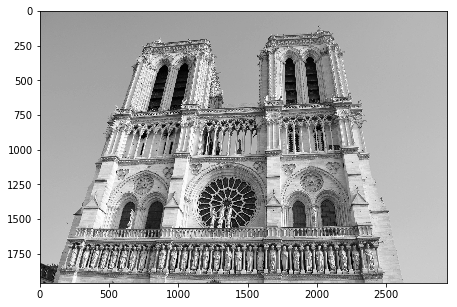

In [4]:
plt.imshow(ND1, "gray"); plt.show()

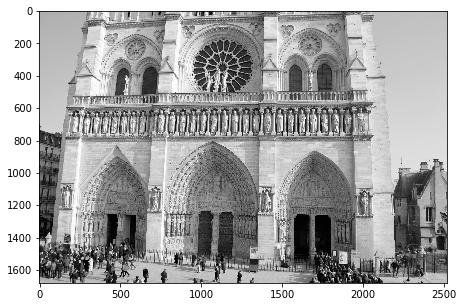

In [5]:
plt.imshow(ND2, "gray"); plt.show()

Utilizzo quindi la funzione stitch creata così da unire le due foto sfruttando una porzione di immagine comune alle due.

L'implementazione funziona nei seguenti passaggi:
1. uso dell'algoritmo SIFT per trovare i keypoints e le features delle foto
2. creazione dei matches tra i keypoints
3. RANSAC così da trovare l'omografia
4. unione finale delle due immagini di partenza.

Dalla funzione ottengo quattro oggetti: 
1. le immagini con i keypoints colorati
2. immagine con i matches (un quinto dei matches sono mostrati nella nostra implementazione)
3. immagine con solo i match coerenti con l'omografia
4. il risultato finale delle immagini unite.


In [6]:
(ND_kps, result_complete, result_homog, final) = stitch(ND1, ND2)

Prima immagine con i keypoints

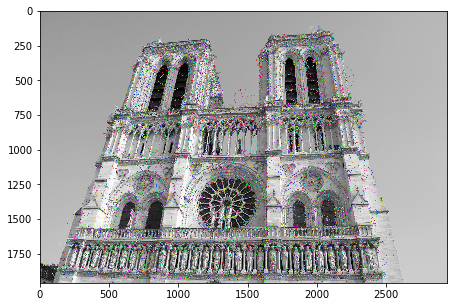

In [7]:
plt.imshow(ND_kps[0], 'gray'); plt.show()

Seconda immagine con i keypoints

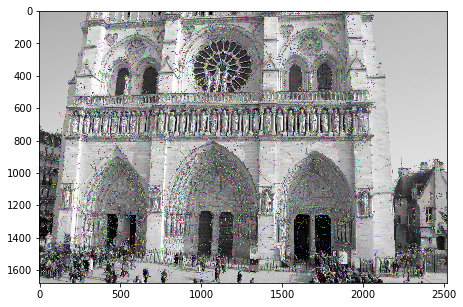

In [61]:
plt.imshow(ND_kps[1], 'gray'); plt.show()

Plot dei matches. Nella funzione impostiamo la visualizzazione di un quinto dei matches perchè troppi.

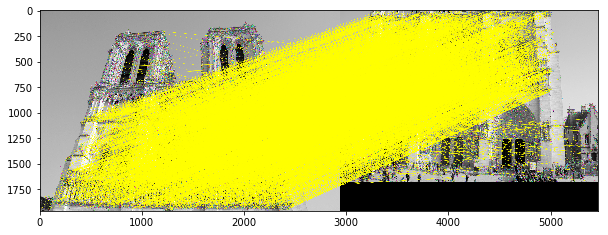

In [62]:
plt.imshow(result_complete, 'gray'); plt.show()

Plot dei matches coerenti con l'omografia.

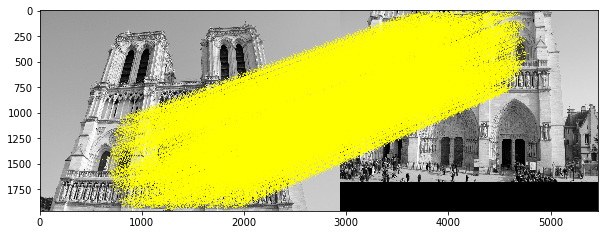

In [63]:
plt.imshow(result_homog, 'gray'); plt.show()

Risultato finale con le due immagini unite.

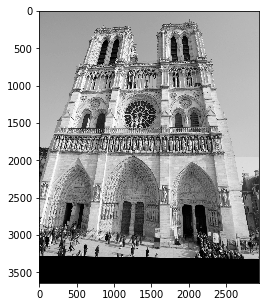

In [64]:
plt.imshow(final, 'gray'); plt.show()

Di default la funzione calcola la dimensione finale dell'unione automaticamente usando la funzione max. Per questo motivo si ottengono bordi neri a seconda degli spazi di sovrapposizione. Settiamo quindi le dimensioni ottimali sempre all'interno della funzione stitch.

In [66]:
(ND_kps, result_complete, result_homog, final) = stitch(ND1, ND2, set_dim=True, set_h=3250, set_w=2940)

Otteniamo così l'immagine finale senza bordi neri superflui.

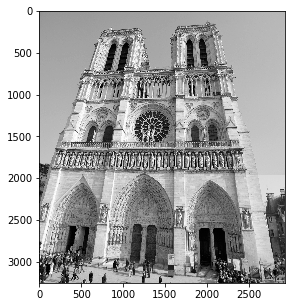

(<matplotlib.image.AxesImage at 0xef09d965f8>, None)

In [67]:
plt.imshow(final, 'gray'),plt.show()

Testiamo ora la funzione con l'immagine a colori.

In [8]:
cm1 = cv.imread("ass1/notredame1.jpg",1)
cm2 = cv.imread("ass1/notredame2.jpg",1)

In [9]:
(ND_kps, img_match, img_homog, img_fin) = stitch(cm1, cm2, direction= "vertical", set_dim=True, set_h=3250, set_w=2940 )

I tre canali rgb sono utilizzati in ordine differente tra Matplotlib e OpenCV. 
Quindi nella visualizzazione del risultato otteniamo dei colori sfalsati.

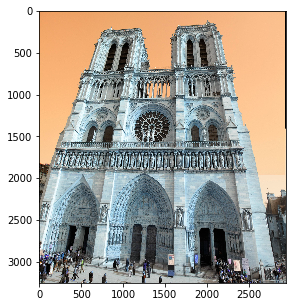

(<matplotlib.image.AxesImage at 0xef134b5c50>, None)

In [69]:
plt.imshow(img_fin),plt.show()

Per risolvere la visualizzazione riordiniamo i tre canali.

Invertendo i canali per ottenere l'immagine a colori reali, cambiamo però anche il colore delle linee dei matches. Questo non crea necessariamente un problema, ma se volessimo cambiare colore (o tornare al colore giallo di default) basta settare il parametro col. 

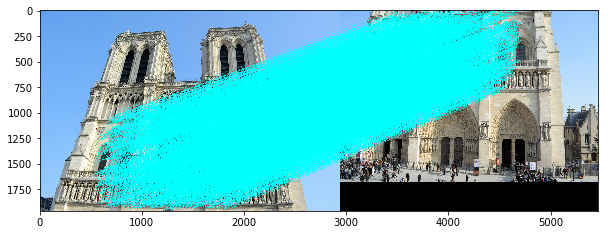

In [71]:
b,g,r = cv.split(img_homog); img_homog = cv.merge([r,g,b])
plt.imshow(img_homog); plt.show()

A seguire lo stitching finale. 

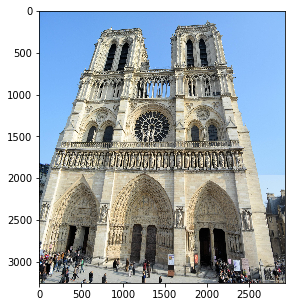

(<matplotlib.image.AxesImage at 0xb9ef37db38>, None)

In [10]:
b,g,r = cv.split(img_fin); img_fin = cv.merge([r,g,b])
plt.imshow(img_fin),plt.show()